# 


In [1]:
import argparse
import json
import logging
import os
import random
import re
from turtle import distance
import torch
import warnings
import pandas as pd
from adjustText import adjust_text
from typing import Tuple, Iterator, List, Dict
from tqdm.notebook import tqdm
import seaborn as sns


import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler
from sklearn.manifold import TSNE


from os.path import join as pjoin
from collections import defaultdict
from scipy.stats import linregress
from torch.optim import Adam, AdamW

os.environ['PYTHONIOENCODING']='UTF-8'
os.environ['CUDA_LAUNCH_BLOCKING']=str(1)

In [2]:
# Enable automatic reloading of modules before executing code
%load_ext autoreload
%autoreload 2


import plotting as pl
from models import model as md
import utils as ut

In [3]:
# create logger
logger = logging.getLogger('ooo-id-joint')
logger.setLevel(logging.INFO)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)

# create formatter
formatter = logging.Formatter(
    fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S'
)

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

In [4]:
task = "odd_one_out"
modality = "behavioral"
triplets_dir = "./data/"
lr = learning_rate = 0.001
lmbda = 0.008
temperature = 1
embed_dim = 5
num_threads = 6
device = "cpu"
batch_size = 100
sampling_method = "normal"
rnd_seed = 42
p = None
results_dir = './results/id-joint/'
plots_dir = './plots/id-joint/'
epochs = 500
distance_metric = "dot"

In [5]:
logger.info("does logging work?")

2025/01/22 14:46:52 - ooo-id-joint - INFO - does logging work?


In [6]:
train_triplets_ID, test_triplets_ID = ut.load_data_ID(device=device, triplets_dir=triplets_dir)
n_items_ID = ut.get_nitems(train_triplets_ID)


...Could not find any .npy files for current modality.
...Now searching for .txt files.



In [7]:
n_participants = len(np.unique(train_triplets_ID.numpy()[:,3]))

In [8]:
#load train and test mini-batches
train_batches, val_batches = ut.load_batches(
    train_triplets=train_triplets_ID,
    test_triplets=test_triplets_ID,
    n_items=n_items_ID,
    batch_size=batch_size,
    sampling_method=sampling_method,
    rnd_seed=rnd_seed,
    p=p, method = "ids"
)

In [9]:
#temperature = torch.tensor(temperature).to(device)
temperature = torch.tensor(temperature).clone().detach()
model = md.SPoSE_ID(
    in_size=n_items_ID, out_size=embed_dim, 
    num_participants=n_participants, init_weights=True)
model.to(device)
optim = Adam(model.parameters(), lr=lr)

In [10]:
logger.info(f'...Creating PATHs')

if results_dir == './results/id-joint/':
    results_dir = os.path.join(results_dir, modality, f'{embed_dim}d', str(lmbda), f'seed{rnd_seed:02d}')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

if plots_dir == './plots/id-joint/':
    plots_dir = os.path.join(plots_dir, modality, f'{embed_dim}d', str(lmbda), f'seed{rnd_seed}')
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

model_dir = os.path.join(results_dir, 'model')

2025/01/22 14:47:00 - ooo-id-joint - INFO - ...Creating PATHs


In [63]:
epochs = 2

In [64]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
start = 0
train_accs, val_accs = [], []
train_losses, val_losses = [], []
loglikelihoods, complexity_losses_ID, complexity_losses_avg = [], [], []
nneg_d_over_time = []

iter = 0
results = {}
logger.info(f'Optimization started for lambda: {lmbda}\n')

print(f'Optimization started for lambda: {lmbda}\n')
for epoch in tqdm(range(start, epochs)):
    model.train()
    batch_llikelihoods = torch.zeros(len(train_batches))
    batch_closses_avg = torch.zeros(len(train_batches))
    batch_closses_ID = torch.zeros(len(train_batches))
    batch_losses_train = torch.zeros(len(train_batches))
    batch_accs_train = torch.zeros(len(train_batches))
    for i, batch in enumerate(train_batches):
        optim.zero_grad() #zero out gradients
        b = batch[0].to(device)
        id = batch[1].to(device)
        logits = model(b, id)
        anchor, positive, negative = torch.unbind(torch.reshape(logits, (-1, 3, embed_dim)), dim=1)
        c_entropy = ut.trinomial_loss(anchor, positive, negative, task, temperature, distance_metric)
        l1_pen_avg = md.l1_regularization(model, "weight").to(device) #L1-norm to enforce sparsity (many 0s)
        l1_pen_ID = md.l1_regularization(model, "individual_slopes", "most").to(device) #L1-norm to enforce sparsity (many 0s)
        W = model.fc.weight
        # positivity constraint to enforce non-negative values in embedding matrix
        pos_pen = torch.sum(F.relu(-W)) + torch.sum(F.relu(-model.individual_slopes.weight))
        complexity_loss_avg = (lmbda/n_items_ID) * l1_pen_avg
        complexity_loss_ID = (lmbda/n_participants) * l1_pen_ID
        # possible options
        # ignore complexity loss on ndimns avg, but enforce sparsity on the number of used dims per individual
        # enforce sparsity on both
        # ignore complexity loss on ndims avg, enforce reverse sparsity (i.e., mostly 1s) on IDs
        # enforce sparsity on ndims avg, and enforce reverse sparsity (i.e., mostly 1s) on IDs
        loss = c_entropy + 0.01 * pos_pen + complexity_loss_ID
        loss.backward()
        optim.step()
        batch_losses_train[i] += loss.item()
        batch_llikelihoods[i] += c_entropy.item()
        batch_closses_ID[i] += complexity_loss_ID.item()
        batch_closses_avg[i] += complexity_loss_avg.item()
        batch_accs_train[i] += ut.choice_accuracy(anchor, positive, negative, task, distance_metric)
        iter += 1

    avg_llikelihood = torch.mean(batch_llikelihoods).item()
    avg_closs_ID = torch.mean(batch_closses_ID).item()
    avg_closs_avg = torch.mean(batch_closses_avg).item()
    avg_train_loss = torch.mean(batch_losses_train).item()
    avg_train_acc = torch.mean(batch_accs_train).item()

    loglikelihoods.append(avg_llikelihood)
    complexity_losses_ID.append(avg_closs_ID)
    complexity_losses_avg.append(avg_closs_avg)
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)

2025/01/23 13:49:45 - ooo-id-joint - INFO - Optimization started for lambda: 0.008



Optimization started for lambda: 0.008



  0%|          | 0/2 [00:00<?, ?it/s]

In [112]:
for n, p in model.named_parameters():
    print(n)
    print(p)

fc.weight
Parameter containing:
tensor([[3.0933e-03, 7.5176e-01, 6.6758e-01,  ..., 5.9722e-04, 5.8544e-01,
         1.1895e-02],
        [2.0860e-03, 5.3019e-01, 5.9172e-01,  ..., 8.8811e-04, 6.7304e-01,
         6.9094e-04],
        [4.2593e-03, 4.0693e-01, 2.2581e-01,  ..., 1.4100e-03, 5.3645e-01,
         1.7510e-03],
        [1.9784e-04, 5.6932e-01, 5.4005e-01,  ..., 9.0605e-04, 5.3989e-01,
         3.7507e-03],
        [1.3470e-02, 5.2020e-01, 5.0976e-01,  ..., 1.1393e-02, 7.4427e-01,
         4.5001e-03]], requires_grad=True)
individual_slopes.weight
Parameter containing:
tensor([[0.0285, 0.0323, 0.9308, 1.0443, 0.2607],
        [0.0236, 0.9995, 0.6127, 0.6147, 1.0108],
        [1.9266, 0.3859, 0.6874, 0.0339, 0.0057],
        ...,
        [1.9172, 0.0336, 0.0410, 1.5586, 1.4081],
        [1.7396, 1.7121, 0.0125, 1.6349, 1.3352],
        [0.2376, 0.0274, 0.1060, 1.0498, 0.1798]], requires_grad=True)


In [134]:
kwd_pattern = fr'{"weight"}'
agreement = "few"
l1_reg = torch.tensor(0., requires_grad=True)
for n, p in model.named_parameters():
    if re.search(kwd_pattern, n):
        if agreement == "few":
            l1_reg = l1_reg + torch.norm(p, 1)
        elif agreement == "most":
            l1_reg = l1_reg + torch.norm(1-p, 1)
        l1_reg = l1_reg + torch.norm(p, 1)


In [135]:
p.shape

torch.Size([264, 5])

In [136]:
l1_reg

tensor(7501.4307, grad_fn=<AddBackward0>)

In [85]:
torch.sum(F.relu(-W)) + torch.sum(F.relu(-model.individual_slopes.weight))

tensor(0.0028, grad_fn=<AddBackward0>)

In [84]:
F.relu(-W)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ReluBackward0>)

In [22]:
md.l1_regularization(model, "individual_slopes", agreement="few").to(device)

tensor(2306.7131, grad_fn=<AddBackward0>)

In [65]:
torch.sum(F.relu(-model.individual_slopes.weight))

tensor(0., grad_fn=<SumBackward0>)

In [83]:
model.individual_slopes.weight.shape

torch.Size([264, 5])

In [66]:
torch.sum(F.relu(-W))

tensor(0.0028, grad_fn=<SumBackward0>)

(array([3226.,  564.,  810., 1251., 1445., 1139.,  555.,  223.,   51.,
           6.]),
 array([-6.75517018e-04,  1.02147125e-01,  2.04969779e-01,  3.07792425e-01,
         4.10615057e-01,  5.13437688e-01,  6.16260350e-01,  7.19083011e-01,
         8.21905673e-01,  9.24728274e-01,  1.02755094e+00]),
 <BarContainer object of 10 artists>)

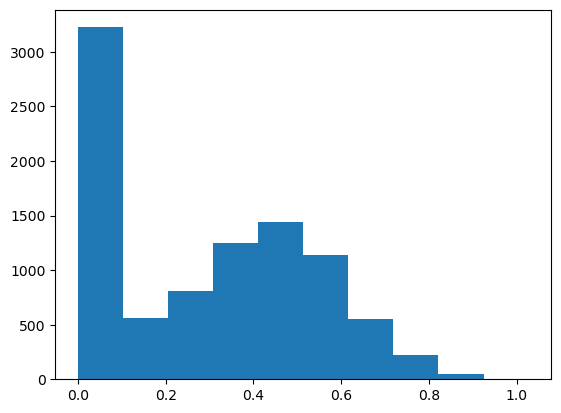

In [78]:
plt.hist(pd.melt(pd.DataFrame(W.detach().numpy()))["value"])

(array([464., 148., 211., 180., 123.,  83.,  52.,  36.,  20.,   3.]),
 array([5.51645440e-09, 3.19797605e-01, 6.39595151e-01, 9.59392786e-01,
        1.27919030e+00, 1.59898794e+00, 1.91878557e+00, 2.23858309e+00,
        2.55838060e+00, 2.87817836e+00, 3.19797587e+00]),
 <BarContainer object of 10 artists>)

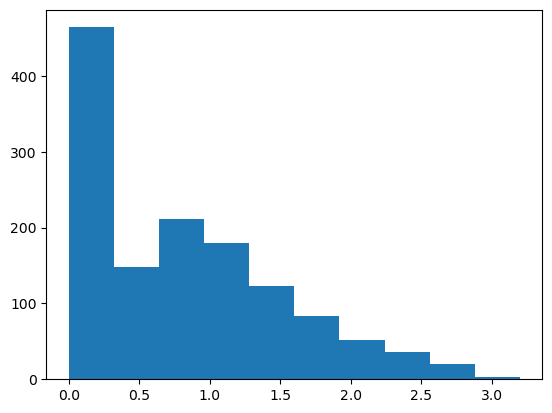

In [81]:
plt.hist(pd.melt(pd.DataFrame(model.individual_slopes.weight.detach().numpy()))["value"])

In [ ]:
torch.norm(model.named_parameters

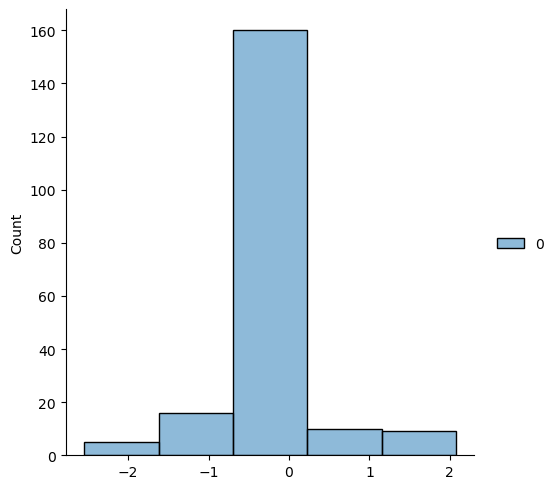

In [32]:
sns.displot(model.individual_slopes(torch.LongTensor([0])).detach().numpy().T, binwidth=1)

In [30]:
ut.validation(model, val_batches, task, device, level_explanation="ID")

(1.0149255990982056, 0.4454909563064575)

In [53]:
anchor = torch.Tensor([[3, 10]])
positive = torch.Tensor([[1, 3]])
negative = torch.Tensor([[7, 5]])

In [54]:
ut.choice_accuracy(anchor, positive, negative, method="odd_one_out")

0.0

In [32]:
model.individual_slopes(torch.LongTensor(1))

tensor([[ 2.0979,  0.2460,  0.0671, -0.6534, -2.1122]],
       grad_fn=<EmbeddingBackward0>)